# Learning from Testimony

This section implements the simulation from: 

K. Zollman (2015). [Modeling the social consequences of testimonial norms](http://www.kevinzollman.com/uploads/5/0/3/6/50361245/zollman_-_modeling_the_social_consequence_of_testimonial_norms.pdf), Philosophical Studies, 172, pp. 2371 - 2383.


Fix a large number of propositions that the individuals want to learn.  For each proposition $P$, an individual either believes $P$, disbelieves $P$ (i.e., believes that $P$ is false)  or suspends judgement about $P$. 

Each individual is endowed with an intrinsic reliability which determines how
likely she is to believe true propositions and disbelieve false ones when she receives
evidence directly from the world. 

At each round, each individual: 

1. with a 10 % chance, individauls receive some new piece of information from direct observation of the world.
2. each individual chooses a group of people from whom to solicit testimony.
3. each individual asks each of the individuals in that group to tell them something that the testifier either believes or disbelieves.
4. the individuals receives an honest report from the asked individual.
5. if the individual told something about which they currently suspend judgment, they believes what they are told. Otherwise they do not change their doxastic attitudes.


The above process is repeated 500 times and the group is evaulated according to two questions: 

1. Did the group maximuze the number of true beliefs? 
2. Did the group minimize the number of false beliefs? 

There are 4 types of agents: 

1. Skeptics do not think testimony is justified, and so do not listen to any other agents and only modify their doxastic attitudes in response to their own evidence from the world. 

2. Credulists have no  reason to stop listening to someone, so they initially choose a set of indivudals to trust and never change this set. 

3. Objective calibrationist only listens to agents that have the most true beliefs. 

4. Subjective calibrationists only listen to the agents that they agree the most with. 

In [2]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import random

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

from enum import Enum

sns.set()

In [3]:
class AgentType(Enum):
    skeptic = 'skeptic' # ignore all testimony
    credulous = 2 # randomly select members of the community to solicit belief reports
    objective_calibrationist = 3 # choose agents that have the highest porportion of true beliefs 
                                 # to solicit belief reports
    subjective_calibrationist = 4 # choose    agents with the highest degree of agreement to solicit belief reports


In [4]:

# Types of beliefs
B = 1     # Believe (Bp)
D = -1    # Disbelieve (B\neg p)
S = 0     # Suspend Judgement (\neg Bp \wedge \neg B\neg p)

class AgentType(Enum):
    skeptic = 1 # ignore all testimony
    credulous = 2 # randomly select members of the community to solicit belief reports
    objective_calibrationist = 3 # choose agents that have the highest porportion of true beliefs 
                                 # to solicit belief reports
    subjective_calibrationist = 4 # choose agents with the highest degree of agreement to solicit belief reports

# A world consists of a set of facts
class World():
    
    def __init__(self,num_facts=100):
        
        # initially randomly assign truth values to each fact
        self.facts=[random.choice([True,False]) for f in range(num_facts)] 

    @property
    def propositions(self): 
        return list(range(len(self.facts)))

    @property
    def num_facts(self): 
        return len(self.facts)
    
    # Return the truth value of proposition f
    def truth_value(self, f):
        return self.facts[f]

class Individual(Agent):

    def __init__(self, 
                 unique_id,
                 model,
                 init_facts_to_investigate = 15,
                 investigate_probability = 0.1,
                 a_type = AgentType.skeptic,
                 num_experts = 2,
                 believe_most_recent=False):

        super().__init__(unique_id, model)
        self.rel = np.random.beta(1.5, 1, size=None) # the probability that the agent believes true facts and disbelieves false ones
        self.investigate_prob = investigate_probability # probability that the agent will investiage
        self.beliefs_from_observation = [S]*self.model.world.num_facts # The agent's beliefs about the facts
        self.beliefs_from_testimony = [S]*self.model.world.num_facts # Testimony from others about the facts
        self.type = a_type # Skeptic, Credulous, Objective Calibrationist or Subjective Calibrationist
        self.believe_most_recent = believe_most_recent # If True, then the agent will believe the most recent report on a fact
        self.num_experts = num_experts
        self.experts = list() # List of agents to receive testimony from
        
        # Initially, choose some facts to investigate
        facts_to_investigate = random.sample(self.model.world.propositions, init_facts_to_investigate)
        for f in facts_to_investigate:
            self.observe(f, self.model.world.truth_value(f))

    # observe truth value tv of fact f
    def update_observed_beliefs(self, f, tv):

        # If currently suspend judgement about fact f, set the belief to tv 
        # (This means that there is no belief revision)
        if self.beliefs_from_observation[f] == S:
            self.beliefs_from_observation[f] = tv


    # Return a list of the agent's beliefs
    # To do this, merge the agent's private_beliefs (what is learned by observation) with social_beliefs (what is learned via testimony)
    # Preference is given to what is learned by observation.
    @property
    def beliefs(self):
        
        return [b[0] if b[0] != S else b[1] 
                for b in zip(self.beliefs_from_observation, self.beliefs_from_testimony)]

    # Return the agent's belief about fact f
    def belief(self, f):

        return self.beliefs_from_observation[f] if self.beliefs_from_observation[f] != S else self.beliefs_from_testimony[f]

    # Observe a fact
    def observe(self, f, tv):

        # With probability self.rel, the agent's private belief is correct
        if random.random() < self.rel:
            self.beliefs_from_observation[f] = B if tv else D  # the belief is correct
        else:
            self.beliefs_from_observation[f] = D if tv else B # the agent believes  a falsehood

    # Learn from testimony of the agent's experts
    def learn_from_testimony(self):

        for e in self.experts:
            f, b = e.report()  # get a report from expert e
            if self.beliefs_from_observation[f] == S: # The agent has not observed f
                if self.believe_most_recent:
                    self.beliefs_from_testimony[f] = b # the agent believes the current report about f
                elif not self.believe_most_recent and self.beliefs_from_testimony[f] == S:
                    self.beliefs_from_testimony[f] = b # only accept the report if the agent currently suspends judgement

    # Return facts that the agent currently suspends judgement
    def unknown_facts(self):

        return [idx for idx, f in enumerate(self.beliefs) if f == S]

    # All the believed facts
    def believed_facts(self):

        return [idx for idx, f in enumerate(self.beliefs) if f == B]

    # All the disbelieved facts
    def disbelieved_facts(self):

        return [idx for idx,f in enumerate(self.beliefs) if f == D]

    # Choose a random fact to report
    def report(self):
        # Find some fact that you believe or disbelieve
        facts = self.believed_facts() + self.disbelieved_facts()
        if len(facts) == 0:
            print("NO BELIEVED FACTS!")
            print(self.rel)
            print(self.private_beliefs)
            return None, None
        f = random.choice(facts)

        # Report your true belief for fact f
        return f, self.belief(f)

    # With probability self.investigate_prob, investigate an unknown fact
    def investigate(self):

        if len(self.unknown_facts()) > 0: # There is something to investigate
            if random.random() < self.investigate_prob: # Investigate with probability self.investigate_prob
                f = random.choice(self.unknown_facts()) # Choose a random fact to observe
                self.observe(f, self.model.world.truth_value(f)) # observe the truth value

    # Return all the facts that are correctly believed
    # Also return the percentage of non-suspended judgement beliefs that are correct
    def correct_beliefs(self):

        bel=self.believed_facts()
        disbel=self.disbelieved_facts()

        correct_bels=[b for b in bel if self.model.world.truth_value(b)] + [b for b in disbel if not self.model.world.truth_value(b)]

        percentage=float(len(correct_bels))/float(len(bel)+len(disbel))

        return correct_bels,percentage

    # Return all the facts that are incorrect
    def false_beliefs(self):

        bel=self.believed_facts()
        disbel=self.disbelieved_facts()

        false_bels=[b for b in bel if not self.model.world.truth_value(b)] + [b for b in disbel if  self.model.world.truth_value(b)]

        percentage=float(len(false_bels))/float(len(bel)+len(disbel))

        return false_bels,percentage

    # Find new experts
    def find_experts(self, initial=False):

        if self.type == AgentType.skeptic:
            self.experts= []

        elif self.type == AgentType.credulous:
            # initially, randomly select num_experts from community, otherwise keep the same experts
            self.experts = random.sample(self.model.schedule.agents, self.num_experts) if  initial else self.experts

        elif self.type == AgentType.objective_calibrationist:
            experts=[]

            # get all the agent's objective abilities
            agent_reliabilities = [(a, a.correct_beliefs()[1]) for a in self.model.schedule.agents]
            
            sorted_agent_reliabilities = sorted(agent_reliabilities, key = lambda x: x[1], reverse=True)
            self.experts = [e[0] for e in sorted_agent_reliabilities[0:self.num_experts]]
            
        elif self.type == AgentType.subjective_calibrationist:
            experts=[]

            # get all the agent's agreements
            agent_agreements = [(a, self.agreement(a)) for a in self.model.schedule.agents]
            
            sorted_agent_agreements = sorted(agent_agreements, key = lambda x: x[1], reverse=True)
            self.experts = [e[0] for e in sorted_agent_agreements[0:self.num_experts]]


    # Of all the beliefs that the agent shares with a, returns the proportion on which they agree
    def agreement(self, a):
        
        # memoize (dis)believed facts
        own_believed_facts = self.believed_facts()
        own_disbelieved_facts = self.disbelieved_facts()
        other_believed_facts =  a.believed_facts()  
        other_disbelieved_facts =  a.disbelieved_facts()
        
        opinions = own_believed_facts  + own_disbelieved_facts
        others_opinions = other_believed_facts  + other_disbelieved_facts

        overlap = set(opinions).intersection(set(others_opinions))

        if len(overlap) == 0:
            return 0

        #agreements = [1 for f in own_believed_facts if f in other_believed_facts] + [1 for f in own_disbelieved_facts if f in other_disbelieved_facts]
        agreements = list(set(own_believed_facts).intersection(set(other_believed_facts))) + list(set(own_disbelieved_facts).intersection(set(other_disbelieved_facts)))
        #agreements = set(self.believed_facts()).intersection(set(a.believed_facts())).union(set(self.disbelieved_facts()).intersection(set(a.disbelieved_facts())))
        #print "agreements: ", agreements
        return float(len(agreements))/float(len(overlap))

class TestimonyModel(Model):

    def __init__(self,
                 num_facts = 100,
                 num_agents = 10,
                 init_facts_to_investigate=5,
                 a_type = AgentType.skeptic,
                 num_experts=2,
                 believe_most_recent=False):

        self.world=World(num_facts=num_facts) # The world
        self.schedule = RandomActivation(self)
        for a_id in range(num_agents):
            a = Individual(a_id, 
                           self, 
                           init_facts_to_investigate=init_facts_to_investigate,
                           a_type = a_type,
                           believe_most_recent=believe_most_recent) 
            self.schedule.add(a)

        # each agent finds some initial experts
        for a in self.schedule.agents:
            a.find_experts(initial=True)


    # Return the average of the proportion of the agent's correct beliefs
    def avg_correct_beliefs(self):

        return np.average([a.correct_beliefs()[1] for a in self.schedule.agents])

    # Returns the average of the proportion of the agent's incorrect beliefs
    def avg_false_beliefs(self):

        return np.average([a.false_beliefs()[1] for a in self.schedule.agents])


    # Return the total number of correct beliefs for each agent
    def total_correct_beliefs(self):

        return [len(a.correct_beliefs()[0]) for a in self.schedule.agents]

    # Return the total number of false beliefs for each agent
    def total_false_beliefs(self):

        return [len(a.false_beliefs()[0]) for a in self.schedule.agents]

    def step(self):
        
        # each agent learns about the world
        for a in self.schedule.agents:
            a.investigate()
            
        # each agent learns from testimony            
        for a in self.schedule.agents:
            a.learn_from_testimony()
            
        # each agent (possibly) finds new experts
        for a in self.schedule.agents:
            a.find_experts(initial=False)
        
        


In [5]:
start = time.time()

# Simulation parameters
NUM_FACTS = 500  # number of facts
INIT_FACTS_TO_INVESTIGATE = 15 # number of facts to initially investigate
NUM_AGENTS = 100 # number of agents
NUM_ROUNDS = 100 # number of rounds
BELIEVE_MOST_RECENT = False # True means that agents will believe the most recent report on a fact

all_number_experts = [2, 4, 6, 8, 10]
data_for_df = {
    a_type: {n_experts: {"correct_beliefs":list(), 
                         "incorrect_beliefs": list(),
                         "avg_num_correct_beliefs": list(),
                         "avg_num_incorrect_beliefs":list()} 
             for n_experts in all_number_experts}
    for a_type in AgentType
}

for a_type in AgentType:
    for n_exp in all_number_experts: 
        m = TestimonyModel(
            num_facts=NUM_FACTS,
            num_agents=NUM_AGENTS,
            init_facts_to_investigate=INIT_FACTS_TO_INVESTIGATE,
            a_type=a_type,
            num_experts=n_exp,
            believe_most_recent=BELIEVE_MOST_RECENT
        )
        
        for t in range(NUM_ROUNDS):
            m.step()
            data_for_df[a_type][n_exp]["correct_beliefs"].append(m.avg_correct_beliefs())
            data_for_df[a_type][n_exp]["incorrect_beliefs"].append(m.avg_false_beliefs())
            data_for_df[a_type][n_exp]["avg_num_correct_beliefs"].append(np.average(m.total_correct_beliefs()))
            data_for_df[a_type][n_exp]["avg_num_incorrect_beliefs"].append(np.average(m.total_false_beliefs()))
            
end = time.time()

print(f"Done: {end-start} seconds")


Done: 2224.3512737751007 seconds


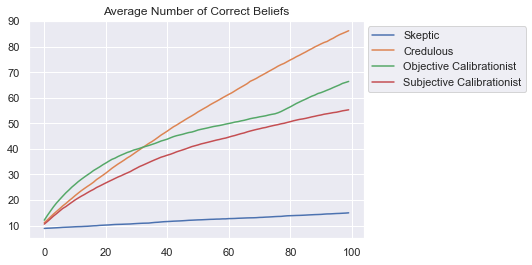

In [6]:
num_experts = 2
belief_type = 'avg_num_correct_beliefs'
plt.plot(data_for_df[AgentType.skeptic][num_experts][belief_type], label="Skeptic")
plt.plot(data_for_df[AgentType.credulous][num_experts][belief_type], label="Credulous")
plt.plot(data_for_df[AgentType.objective_calibrationist][num_experts][belief_type], label="Objective Calibrationist")
plt.plot(data_for_df[AgentType.subjective_calibrationist][num_experts][belief_type], label="Subjective Calibrationist")

plt.legend(bbox_to_anchor=(1.5, 1.))
plt.title("Average Number of Correct Beliefs")
plt.show();

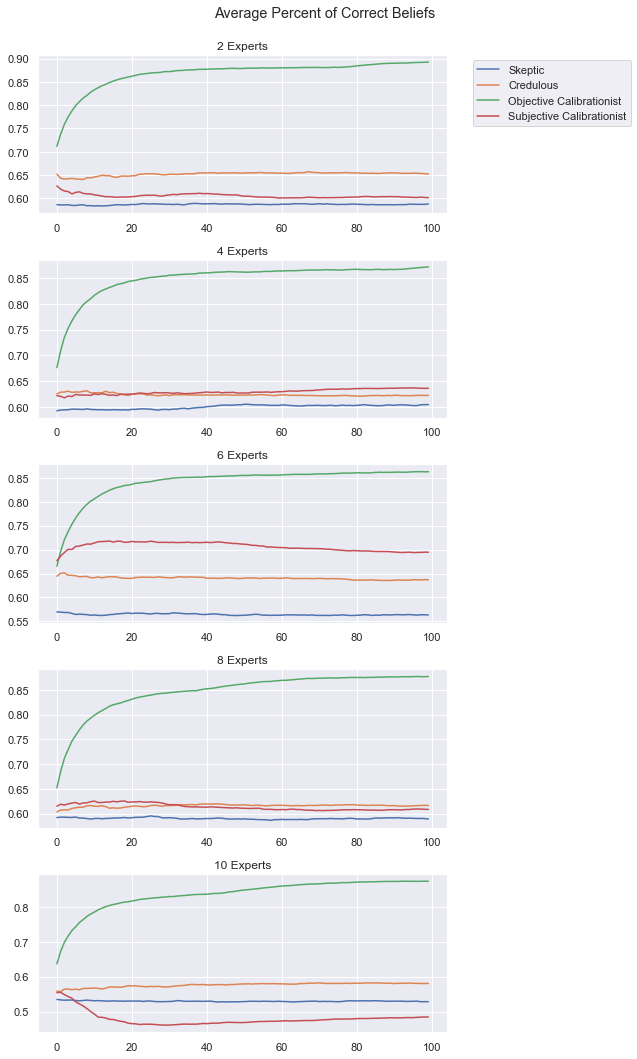

In [27]:
belief_type = 'correct_beliefs'
fig,axs = plt.subplots(nrows=len(all_number_experts), figsize=(9,15))

for ne_idx, ne in enumerate(all_number_experts):
    axs[ne_idx].plot(data_for_df[AgentType.skeptic][ne][belief_type], label="Skeptic")
    axs[ne_idx].plot(data_for_df[AgentType.credulous][ne][belief_type], label="Credulous")
    axs[ne_idx].plot(data_for_df[AgentType.objective_calibrationist][ne][belief_type], label="Objective Calibrationist")
    axs[ne_idx].plot(data_for_df[AgentType.subjective_calibrationist][ne][belief_type], label="Subjective Calibrationist")
    axs[ne_idx].set_title(f"{ne} Experts")
axs[0].legend(bbox_to_anchor=(1.05, 1.))

plt.suptitle(f"Average Percent of Correct Beliefs\n")
plt.tight_layout()
plt.show();

In [19]:
class TestimonyModelDifferentAgentTypes(Model):

    def __init__(self,
                 num_facts = 100,
                 init_facts_to_investigate=5,
                 agent_types = {AgentType.skeptic:2},
                 believe_most_recent=False):

        self.world=World(num_facts=num_facts) # The world
        self.schedule = RandomActivation(self)
        self.agent_types = list(agent_types.keys())
        self.num_agents = sum(agent_types.values())
        a_id = 0
        for a_type, num in agent_types.items():
            
            for _ in range(num):
                
                a = Individual(a_id, 
                               self, 
                               init_facts_to_investigate=init_facts_to_investigate,
                               a_type = a_type,
                               believe_most_recent=believe_most_recent) 
                self.schedule.add(a)
                a_id += 1

        # each agent finds some initial experts
        for a in self.schedule.agents:
            a.find_experts(initial=True)


    # Return the average of the proportion of the agent's correct beliefs
    def avg_correct_beliefs(self, a_types = None):

        a_types = a_types if a_types is not None else self.agent_types
        return np.average([a.correct_beliefs()[1] for a in self.schedule.agents if a.type in a_types])

    # Returns the average of the proportion of the agent's incorrect beliefs
    def avg_false_beliefs(self, a_types = None):
        a_types = a_types if a_types is not None else self.agent_types

        return np.average([a.false_beliefs()[1] for a in self.schedule.agents if a.type in a_types])


    # Return the total number of correct beliefs for each agent
    def total_correct_beliefs(self, a_types = None):
        a_types = a_types if a_types is not None else self.agent_types

        return [len(a.correct_beliefs()[0]) for a in self.schedule.agents if a.type in a_types]

    # Return the total number of false beliefs for each agent
    def total_false_beliefs(self, a_types = None):
        a_types = a_types if a_types is not None else self.agent_types

        return [len(a.false_beliefs()[0]) for a in self.schedule.agents if a.type in a_types]

    def step(self):
        
        # each agent learns about the world
        for a in self.schedule.agents:
            a.investigate()
            
        # each agent learns from testimony            
        for a in self.schedule.agents:
            a.learn_from_testimony()
            
        # each agent (possibly) finds new experts
        for a in self.schedule.agents:
            a.find_experts(initial=False)
        
        


In [9]:
start = time.time()

# Simulation parameters
NUM_FACTS = 500  # number of facts
INIT_FACTS_TO_INVESTIGATE = 15 # number of facts to initially investigate
NUM_AGENTS = 100 # number of agents
NUM_ROUNDS = 100 # number of rounds
BELIEVE_MOST_RECENT = False # True means that agents will believe the most recent report on a fact

all_number_experts = [2, 4, 6, 8, 10]
data_varying_experts = {
    n_experts: {
        AgentType.skeptic: {
            "correct_beliefs":list(), 
            "incorrect_beliefs": list(),
            "avg_num_correct_beliefs": list(),
            "avg_num_incorrect_beliefs":list()
        },
        AgentType.credulous: {
            "correct_beliefs":list(), 
            "incorrect_beliefs": list(),
            "avg_num_correct_beliefs": list(),
            "avg_num_incorrect_beliefs":list()
        },
        AgentType.objective_calibrationist: {
            "correct_beliefs":list(), 
            "incorrect_beliefs": list(),
            "avg_num_correct_beliefs": list(),
            "avg_num_incorrect_beliefs":list()
        },
        AgentType.subjective_calibrationist: {
            "correct_beliefs":list(), 
            "incorrect_beliefs": list(),
            "avg_num_correct_beliefs": list(),
            "avg_num_incorrect_beliefs":list()
        },
        "all": {
            "correct_beliefs":list(), 
            "incorrect_beliefs": list(),
            "avg_num_correct_beliefs": list(),
            "avg_num_incorrect_beliefs":list()
        }}
    for n_experts in all_number_experts
}


agent_types = {
    AgentType.skeptic: 25,
    AgentType.credulous: 15,
    AgentType.objective_calibrationist: 10,
    AgentType.subjective_calibrationist: 50
}
for n_exp in all_number_experts: 
    m = TestimonyModelDifferentAgentTypes(
        num_facts=NUM_FACTS,
        init_facts_to_investigate=INIT_FACTS_TO_INVESTIGATE,
        agent_types=agent_types,
        believe_most_recent=BELIEVE_MOST_RECENT
    )
    for t in range(NUM_ROUNDS):
        m.step()
        data_varying_experts[n_exp]['all']["correct_beliefs"].append(m.avg_correct_beliefs())
        data_varying_experts[n_exp]['all']["incorrect_beliefs"].append(m.avg_false_beliefs())
        data_varying_experts[n_exp]['all']["avg_num_correct_beliefs"].append(np.average(m.total_correct_beliefs()))
        data_varying_experts[n_exp]['all']["avg_num_incorrect_beliefs"].append(np.average(m.total_false_beliefs()))
            
        for a_type in agent_types.keys():
            data_varying_experts[n_exp][a_type]["correct_beliefs"].append(m.avg_correct_beliefs(a_types=[a_type]))
            data_varying_experts[n_exp][a_type]["incorrect_beliefs"].append(m.avg_false_beliefs(a_types=[a_type]))
            data_varying_experts[n_exp][a_type]["avg_num_correct_beliefs"].append(np.average(m.total_correct_beliefs(a_types=[a_type])))
            data_varying_experts[n_exp][a_type]["avg_num_incorrect_beliefs"].append(np.average(m.total_false_beliefs(a_types=[a_type])))

end = time.time()

print(f"Done: {end-start} seconds")



Done: 833.738924741745 seconds


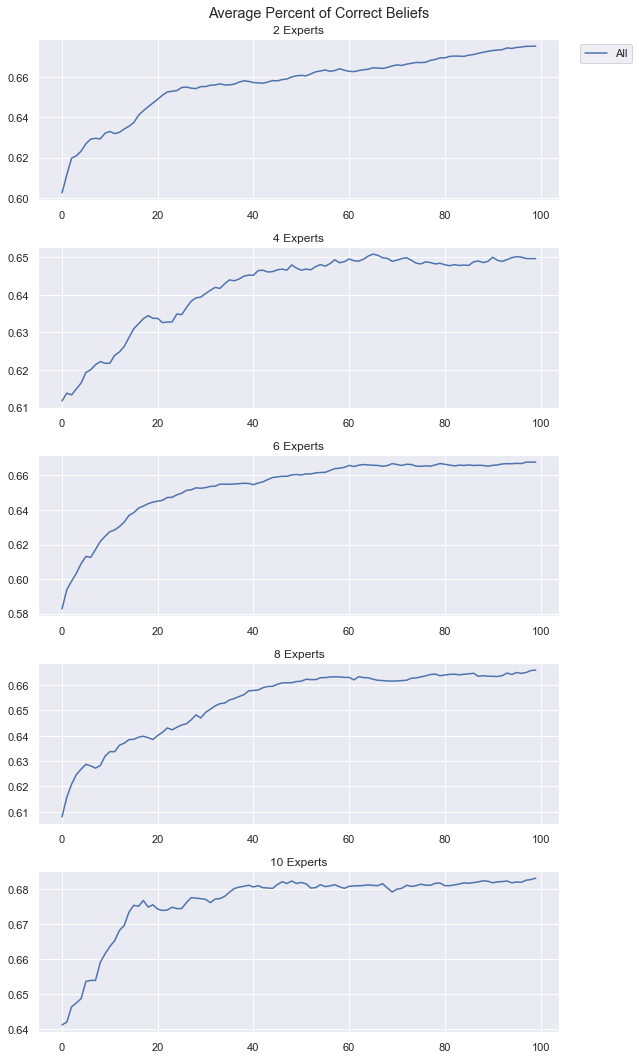

In [31]:
belief_type = 'correct_beliefs'
fig,axs = plt.subplots(nrows=len(all_number_experts), figsize=(9,15))

for ne_idx, ne in enumerate(all_number_experts):
    axs[ne_idx].plot(data_varying_experts[ne]['all'][belief_type], label="All")
    axs[ne_idx].set_title(f"{ne} Experts")
axs[0].legend(bbox_to_anchor=(1.15, 1.))

plt.suptitle("Average Percent of Correct Beliefs")
plt.tight_layout()
plt.show();

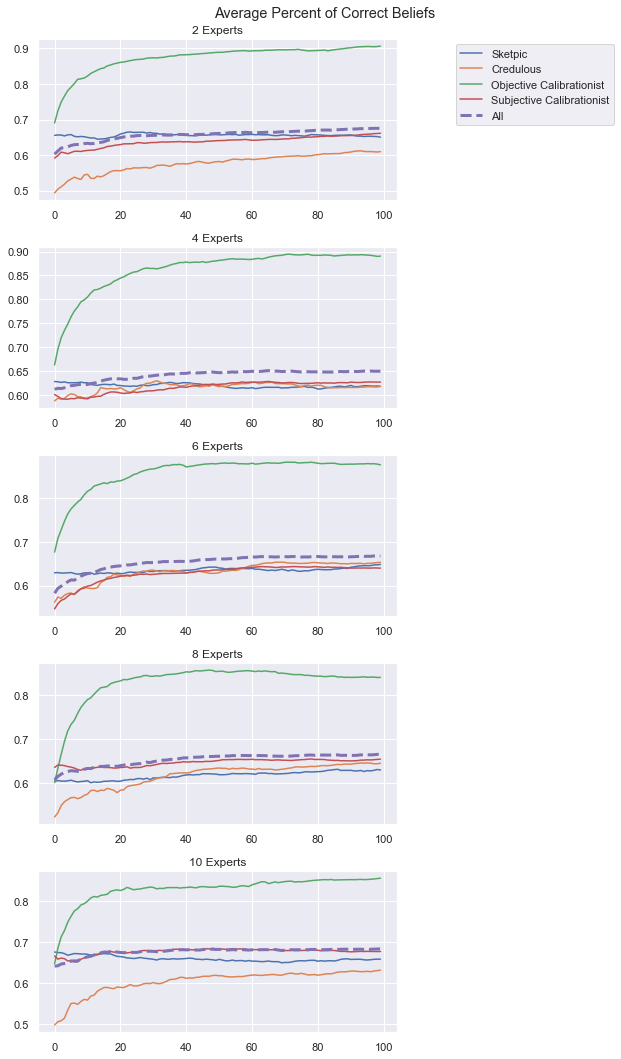

In [30]:
belief_type = 'correct_beliefs'
fig,axs = plt.subplots(nrows=len(all_number_experts), figsize=(9,15))

for ne_idx, ne in enumerate(all_number_experts):
    axs[ne_idx].plot(data_varying_experts[ne][AgentType.skeptic][belief_type], label="Sketpic")
    axs[ne_idx].plot(data_varying_experts[ne][AgentType.credulous][belief_type], label="Credulous")
    axs[ne_idx].plot(data_varying_experts[ne][AgentType.objective_calibrationist][belief_type], label="Objective Calibrationist")
    axs[ne_idx].plot(data_varying_experts[ne][AgentType.subjective_calibrationist][belief_type], label="Subjective Calibrationist")
    axs[ne_idx].plot(data_varying_experts[ne]['all'][belief_type], "--", linewidth=3,label="All")
    axs[ne_idx].set_title(f"{ne} Experts")
axs[0].legend(bbox_to_anchor=(1.15, 1.))

plt.suptitle("Average Percent of Correct Beliefs")
plt.tight_layout()
plt.show();

## Further Reading

C. Mayo-Wilson (2014). [Reliability of testimonial norms in scientific communities](https://link.springer.com/article/10.1007/s11229-013-0320-2), Synthese, 191, pp. 55 - 78.

C. Merdes, M. von Sydow and U. Hahn (2020). [Formal models of source reliability](https://link.springer.com/content/pdf/10.1007/s11229-020-02595-2.pdf), Synthese, 
https://doi.org/10.1007/s11229-020-02595-2

